## Notebook EDA

## ML Challenge #23 

Import Data JSONs

In [120]:
import json
import pandas as pd

import pandas as pd
train_df = pd.read_json ("data/train.json")
train_df.head()

test_df = pd.read_json ("data/test.json")
test_df.head()

,paperId,title,abstract,year,venue
0,86e1aaa0c47659e08a896e9889384eb1e5401e6a,Exploring the Linear Subspace Hypothesis in Ge...,Bolukbasi et al. (2016) presents one of the fi...,2020,EMNLP
1,8d3076c38f56df22052567f4783c670d8e860f09,HyKnow: End-to-End Task-Oriented Dialog Modeli...,Task-oriented dialog (TOD) systems typically m...,2021,FINDINGS
2,7c400ee676d427eeda1aad5c1c54c316f0b9773d,A Multilingual Information Extraction Pipeline...,We introduce an advanced information extractio...,2018,EMNLP
3,185e7d2a761594451b02ace240356dadad2aef78,Dice Loss for Data-imbalanced NLP Tasks,Many NLP tasks such as tagging and machine rea...,2019,ACL
4,e4363d077a890c8d5c5e66b82fe69a1bbbdd5c80,Attention Guided Graph Convolutional Networks ...,Dependency trees convey rich structural inform...,2019,ACL


Check for missing values

In [121]:
train_df.isna().any().any()

False

Data info (types)

In [122]:
train_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12129 entries, 0 to 12128
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   paperId     12129 non-null  object
 1   title       12129 non-null  object
 2   authorId    12129 non-null  int64 
 3   authorName  12129 non-null  object
 4   abstract    12129 non-null  object
 5   year        12129 non-null  int64 
 6   venue       12129 non-null  object
dtypes: int64(2), object(5)
memory usage: 663.4+ KB


No empty columms, 7 columns, 12129 rows, types of the variables are seen in Dtype.
POI: Year and AuthorID are loaded as int64, instead of objects.


Check feature stats

In [123]:


train_df["authorId"].value_counts()

1750769       13
1747849       13
51042088      12
2854981       12
3422953       11
              ..
40192974       1
2013172        1
2106294609     1
5677323        1
144928136      1
Name: authorId, Length: 5625, dtype: int64

In [124]:
train_df["venue"].value_counts()

ACL                                                                          2860
EMNLP                                                                        2247
NAACL                                                                        1023
*SEMEVAL                                                                      470
FINDINGS                                                                      399
                                                                             ... 
DLG4NLP                                                                         1
SCAI                                                                            1
ACL 2020                                                                        1
bioRxiv                                                                         1
Proceedings of the Workshop on Generalization in the Age of Deep Learning       1
Name: venue, Length: 362, dtype: int64

In [125]:
train_df["year"].value_counts().head(8)


2019    1845
2021    1839
2020    1723
2018    1361
2016    1014
2017    1000
2015     901
2014     800
Name: year, dtype: int64

Unique Rows

In [126]:
len(train_df.paperId.unique())

12129

In [127]:
len(train_df.title.unique())

12120

In [128]:
len(train_df.abstract.unique())

12124

Number of unique paperId is equal to rows, paperId is main key.

## Check for correlations

In [129]:
from dython.nominal import associations

df = train_df.apply(
    lambda x: x.astype("object") if x.dtype == "int64" else x)
df = df[[i for i in df.columns if i in ('authorId','year','venue')]]

df.head()

,authorId,year,venue
0,3188285,2014,CLPsych@ACL
1,2782720,2018,Fig-Lang@NAACL-HLT
2,144748442,2021,ACL
3,46331602,2022,ACL
4,30887404,2019,FINDINGS


In [130]:
from sklearn import preprocessing

label = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame() 

for i in df.columns :
  data_encoded[i]=label.fit_transform(df[i])

data_encoded.head()  

,authorId,year,venue
0,1571,35,58
1,1250,39,122
2,4134,42,5
3,3038,43,5
4,2444,40,119


In [131]:
from scipy.stats import chi2_contingency
import numpy as np

def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

rows= []

for var1 in data_encoded:
  col = []
  for var2 in data_encoded :
    cramers =cramers_V(data_encoded[var1], data_encoded[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df2 = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)

df2

,authorId,year,venue
authorId,1.00,0.48,0.51
year,0.48,1.00,0.10
venue,0.51,0.10,1.00


In [132]:
## number of characters in the text 

train_df["num_chars"] = train_df["abstract"].apply(lambda x: len(str(x)))



In [133]:
#import 
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
eng_stopwords = set(stopwords.words("english"))
import string

## Number of words in the text ##
train_df["num_words"] = train_df["abstract"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train_df["num_unique_words"] = train_df["abstract"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train_df["num_chars"] = train_df["abstract"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train_df["num_stopwords"] = train_df["abstract"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Number of punctuations in the text ##
train_df["num_punctuations"] =train_df['abstract'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
train_df["num_words_upper"] = train_df["abstract"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train_df["num_words_title"] = train_df["abstract"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train_df["mean_word_len"] = train_df["abstract"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dirk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [134]:
train_id = train_df['authorId'].values
test_id = validation_df['authorId'].values

### recompute the trauncated variables again ###
train_df["num_words"] = train_df["abstract"].apply(lambda x: len(str(x).split()))
train_df["mean_word_len"] = train_df["abstract"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))


cols_to_drop = ['authorId', 'abstract']


In [135]:
from sklearn.model_selection import train_test_split
#Train test split
train_df, validation_df = train_test_split(train_df, test_size=0.2)

train_X = train_df.drop(cols_to_drop+['authorName'], axis=1)
validation_X = validation_df.drop(cols_to_drop, axis=1)

C:\Users\Dirk\AppData\Local\Temp\ipykernel_12680\1710841664.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['num_words'].loc[train_df['num_words']>180] = 180 #truncation for better visuals


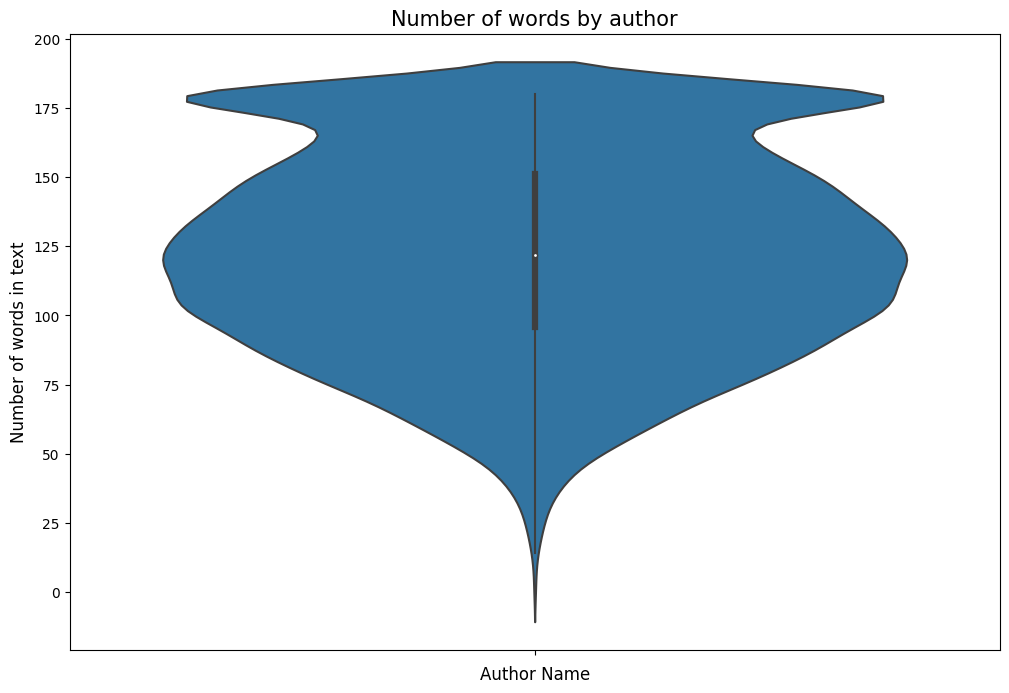

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

train_df['num_words'].loc[train_df['num_words']>180] = 180 #truncation for better visuals
plt.figure(figsize=(12,8))
sns.violinplot(y='num_words', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of words in text', fontsize=12)
plt.title("Number of words by author", fontsize=15)
plt.show()    

In [ ]:
train_df['num_punctuations'].loc[train_df['num_punctuations']>10] = 10 #truncation for better visuals
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_punctuations', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of puntuations in text', fontsize=12)
plt.title("Number of punctuations by author", fontsize=15)
plt.show()



In [137]:
#feature importance (variables) Verder nakijken. 
% pip install xgboost
import xgboost as xgb
fig, ax = plt.subplots(figsize=(8,6))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

UsageError: Line magic function `%` not found.


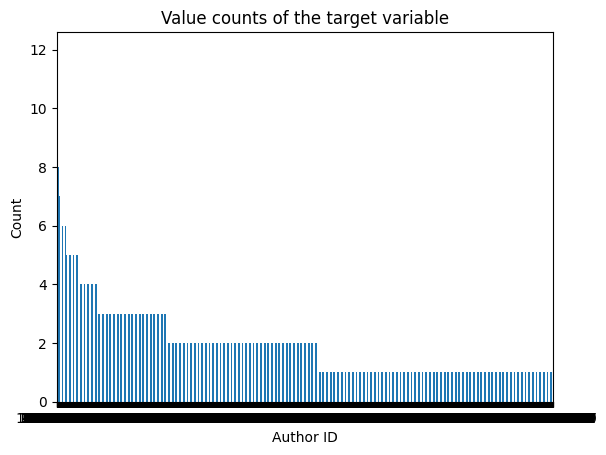

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

train_df.authorId.value_counts().plot(kind="bar")
plt.title("Value counts of the target variable")
plt.xlabel("Author ID")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.show()


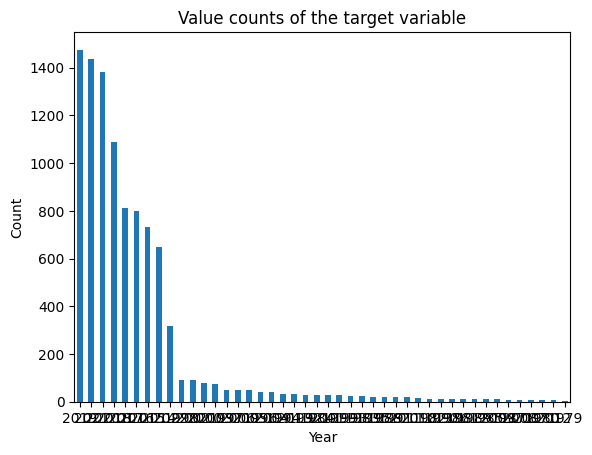

In [139]:
train_df.year.value_counts().plot(kind="bar")
plt.title("Value counts of the target variable")
plt.xlabel("Year")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.show()

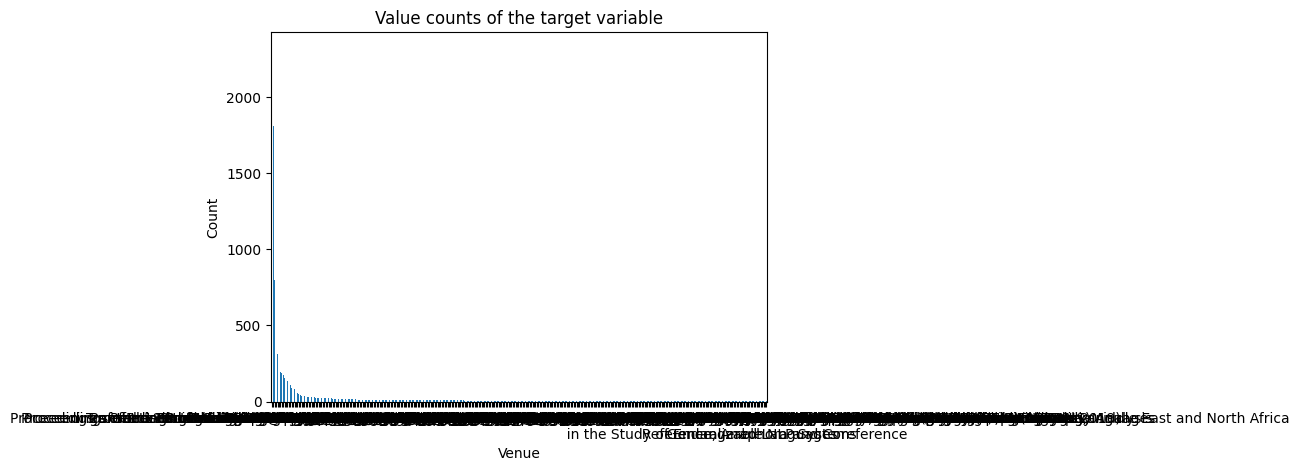

In [140]:
train_df.venue.value_counts().plot(kind="bar")
plt.title("Value counts of the target variable")
plt.xlabel("Venue")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.show()

In [141]:
# PairGrid object with hue
graph = sns.PairGrid(train_df)
# type of graph for non-diagonal(upper part)
graph = graph.map_upper(sns.scatterplot)
# type of graph for non-diagonal(lower part)
graph = graph.map_lower(sns.kdeplot)
# type of graph for diagonal
graph = graph.map_diag(sns.kdeplot, lw = 2)
# to show
plt.show()

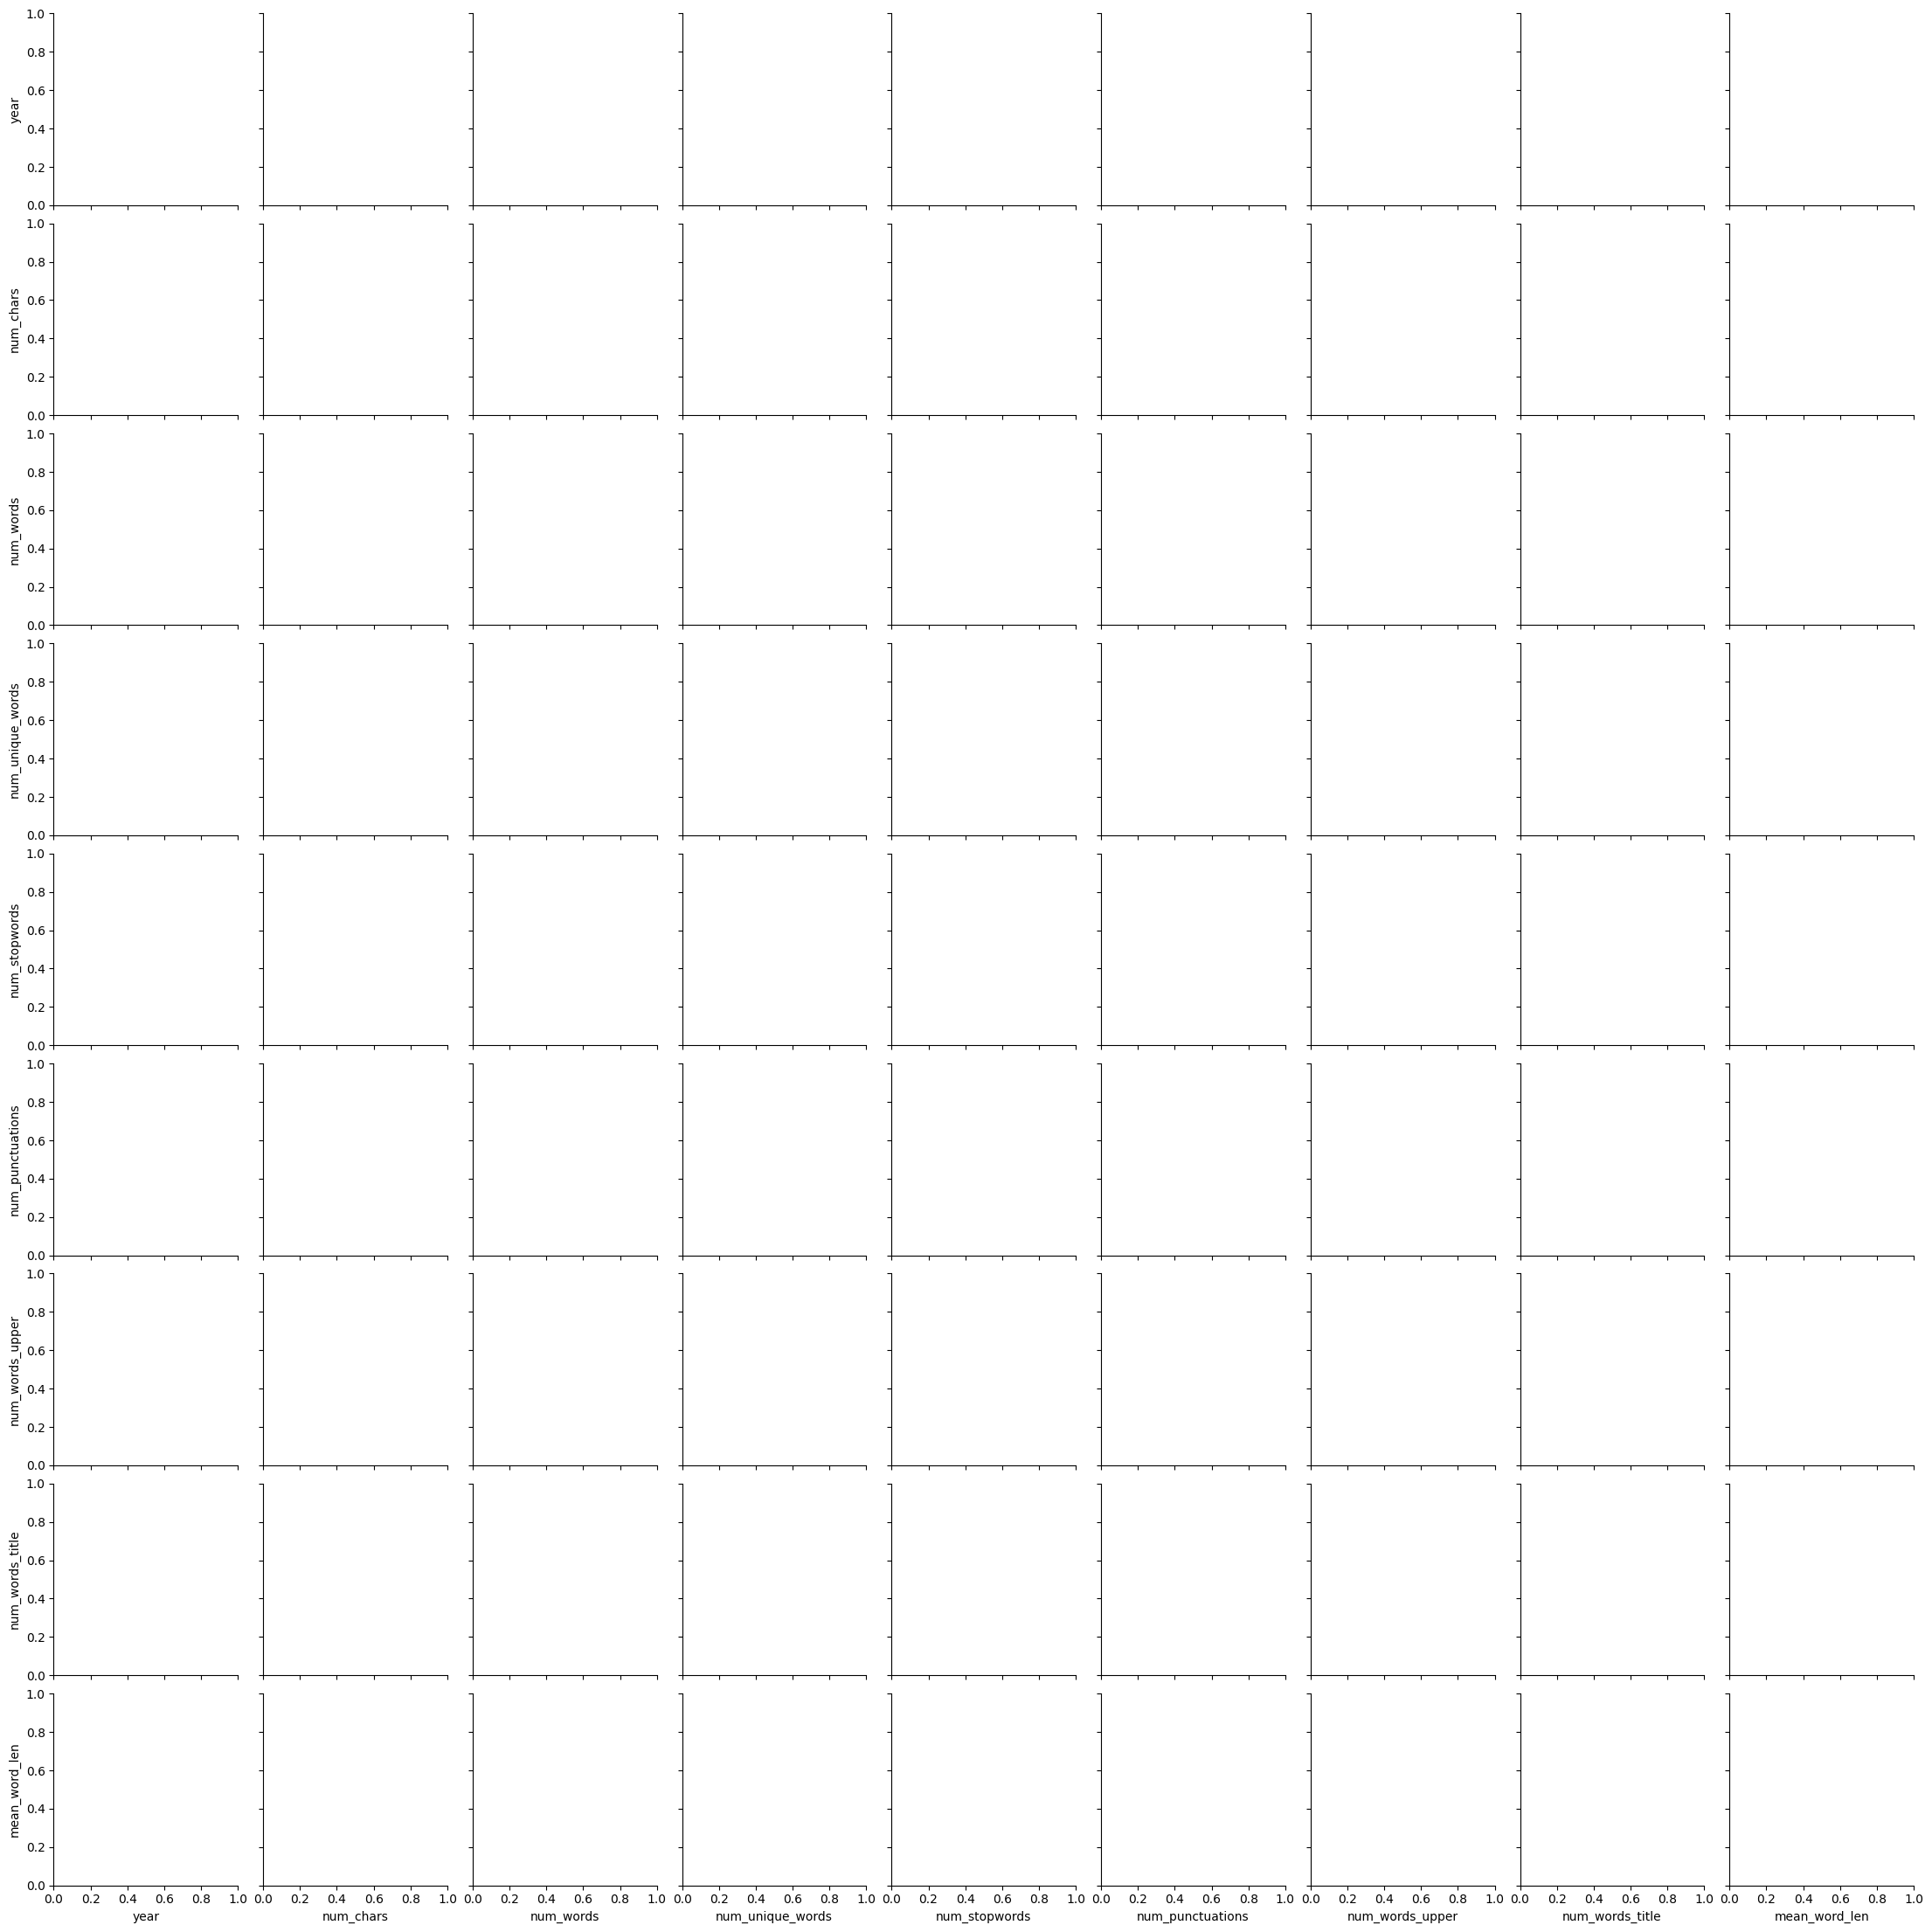

C:\Users\Dirk\AppData\Local\Temp\ipykernel_12680\792816511.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = train_df.corr()


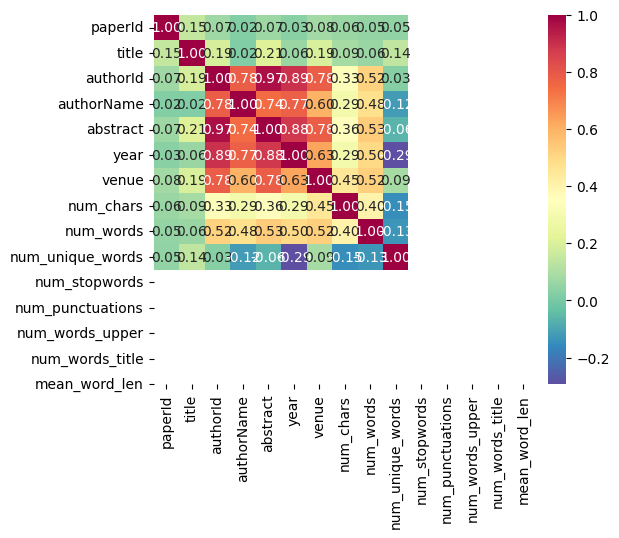

In [ ]:
sns.PairGrid(train_df, hue = "authorId")
plt.show()

train_df.head()
corrmat = train_df.corr()
hm = sns.heatmap(corrmat, 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels=train_df.columns, 
                 xticklabels=train_df.columns, 
                 cmap="Spectral_r")
plt.show()